In [1]:
%load_ext autoreload
%autoreload 2

In [203]:
import networkx as nx
from graphviz import Digraph, Source
from pygraphviz import AGraph
import numpy as np
import matplotlib.image as mpimg
from IPython.display import Image
import matplotlib.pyplot as plt
from flow import main, Node, CreditFlow, Graph, get_source_nodes, topo_sort, flatten_graph, eval_graph
import copy

10 nodes


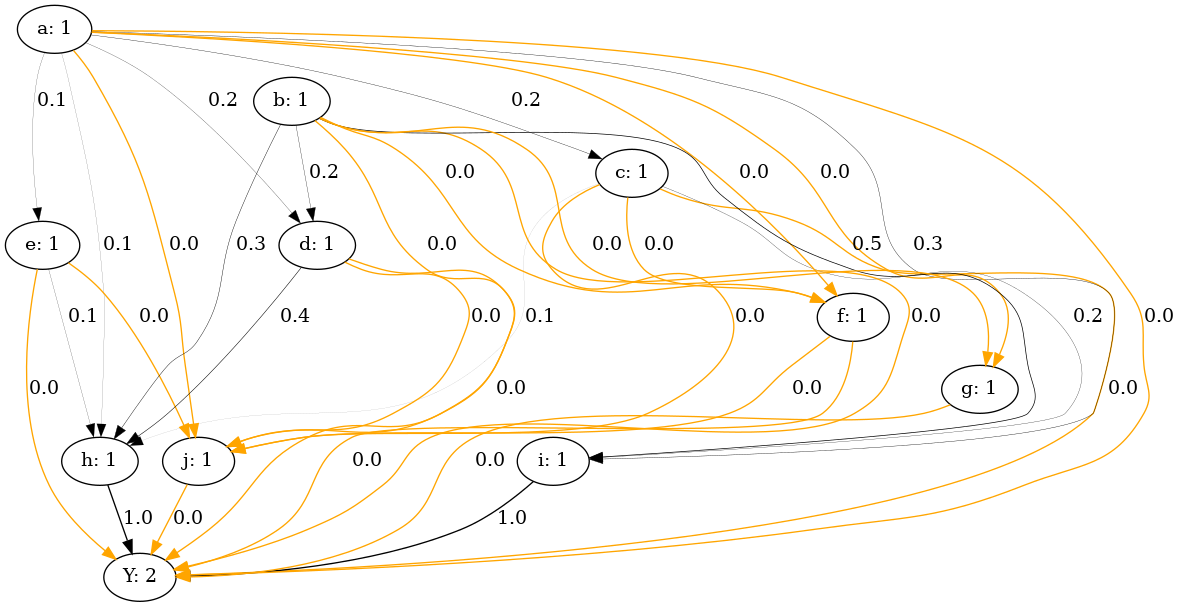

In [346]:
def build_random_graph(n_nodes=10):
    nodes = []
    name = 'a'
    for _ in range(n_nodes):
        args = [nodes[i] for i in range(0 if len(nodes) == 0 else np.random.choice(len(nodes)))]
        node = Node(name, lambda *args: int(sum(args) >= len(args)), args) # and function
        # node = Node(name, lambda *args: int(sum(args) >= 1), args) # or function
        name = chr(ord(name) + 1)
        nodes.append(node)

    print(len(nodes), "nodes")
    source_nodes = get_source_nodes(nodes)
    n_relevant_features = np.random.choice(range(1, len(nodes)))
    feature_mask = np.random.choice(range(1, len(nodes)), n_relevant_features, replace=False)
    args = nodes
    target_node = Node('Y', lambda *args: sum([arg for i, arg in enumerate(args) if i in feature_mask]), 
                       args, is_target_node=True)
    nodes.append(target_node)
    
    graph = Graph(nodes,
                  dict((node.name, lambda: 0) for node in source_nodes),
                  dict((node.name, lambda: 1) for node in source_nodes),
                  )
    return graph

graph = build_random_graph()
verbose = False
cf = CreditFlow(graph, verbose=verbose, nruns=100, visualize=verbose)
cf.run()

dot = cf.credit2dot(format_str="{:.1f}")
dot.write_png('graph.png')
Image('graph.png')

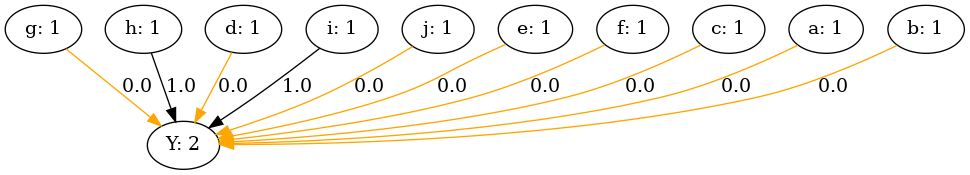

In [347]:
shap_graph = flatten_graph(graph)
verbose = False
cf = CreditFlow(shap_graph, verbose=verbose, nruns=100, visualize=verbose)
cf.run()

dot = cf.credit2dot(format_str="{:.1f}")
dot.write_png('graph.png')
Image('graph.png')

# Simulation of node intervention

In [215]:
sources = get_source_nodes(graph)
d = dict((node.name, 0) for node in sources)
d.update({'d': 1})
print('output:', eval_graph(graph, d))

output: 3


# TODO: set arbitrary boundary

In [348]:
def merge_h(node1, node2):
    '''assume node 1 depend on node2, otherwise return node1'''
    if node2 in node1.args:

        def create_f(node1, node2):
            def f(*args):
                node2_args, node1_args = args[:len(node2.args)], args[len(node2.args):]
                v = node2.f(*node2_args)
                args = []
                idx = 0
                for a in node1.args:
                    if a.name == node2.name:
                        args.append(v)
                    else:
                        args.append(node1_args[idx])
                        idx += 1
                return node1.f(*args)
            return f

        args = node2.args + [a for a in node1.args if a.name != node2.name]
        node1 = Node(node1.name, create_f(node1, node2), args)

    return node1

def merge_nodes(nodes):
    '''
    nodes: assume nodes follow topological order, with the last being the target
    '''
    y = nodes[-1]
    for node in nodes[:-1][::-1]:
        y = merge_h(y, node)
        y.is_target_node = True
        print(f'merging {y} and {node}') ##############
        print(y, y.args, y.children) ##################
    
    # rewire parents
    # add dummy nodes on the boundary
    dummy_nodes = [Node(arg.name + '_dummy{}'.format(i), lambda x: x, [arg],
                        is_noise_node=True) for i, arg in enumerate(y.args)]
    y.args = dummy_nodes
    # print('y output', y.f(1,2)) ###########################
    
    for node in dummy_nodes:
        node.children = [y]
        for parent in node.args:
            print('before', parent, parent.args, parent.children) ###################
            
    # remove link to old node
    for node in dummy_nodes:
        for parent in node.args:
            for n in nodes:
                if n.name in [c.name for c in parent.children]:
                    parent.children = [c for c in parent.children if c.name != n.name]
    
    return y, dummy_nodes
        
def boundary_graph(graph, boundary_nodes):
    '''
    boundary nodes are names of nodes on the boundary
    we collapse all model nodes into a single node
    '''
    # find the boundary node's ancestor and include it in the graph with dfs
    boundary_nodes = [node for node in graph if node.name in boundary_nodes]
    visited = set()
    def dfs(node):
        if node in visited: return
        visited.add(node)
        for n in node.args:
            dfs(n)
    
    for node in boundary_nodes:
        dfs(node)
    boundary_nodes = node.name for node in visited
    print('boundary nodes', boundary_nodes)
    
    nodes_in_d = [] # data side
    nodes_to_merge = []
    graph = copy.deepcopy(graph)
    
    for node in graph:
        print('first', node, node.args, node.children) ##############
        
    for node in topo_sort(graph):
        if node.name not in boundary_nodes:
            nodes_to_merge.append(node)
            if node.is_target_node:
                break
        else:
            nodes_in_d.append(node)
    
    node, dummy_nodes = merge_nodes(nodes_to_merge)
    nodes = nodes_in_d + [node] + dummy_nodes
    for node in nodes:
        print('after', node, node.args, node.children)

    return Graph(nodes, graph.baseline_sampler, graph.target_sampler)
        
print(get_source_nodes(graph))
boundary_graph = boundary_graph(graph, [node.name for node in get_source_nodes(graph)])
verbose = False
cf = CreditFlow(boundary_graph, verbose=verbose, nruns=1, visualize=verbose)
cf.run()

dot = cf.credit2dot(format_str="{:.1f}")
dot.write_png('graph.png')
Image('graph.png')

[b, a]
boundary nodes [b, a]
first b [] [d, f, g, h, i, j, Y]
first g [a, b] [Y]
first i [a, b, c] [Y]
first e [a] [h, j, Y]
first h [a, b, c, d, e] [Y]
first j [a, b, c, d, e, f] [Y]
first a [] [c, d, e, f, g, h, i, j, Y]
first Y [a, b, c, d, e, f, g, h, i, j] []
first c [a] [f, h, i, j, Y]
first d [a, b] [h, j, Y]
first f [a, b, c] [j, Y]
merging Y and g
Y [a, b, a, b, c, d, e, f, h, i, j] []
merging Y and j
Y [a, b, c, d, e, f, a, b, a, b, c, d, e, f, h, i] []
merging Y and h
Y [a, b, c, d, e, a, b, c, d, e, f, a, b, a, b, c, d, e, f, i] []
merging Y and i
Y [a, b, c, a, b, c, d, e, a, b, c, d, e, f, a, b, a, b, c, d, e, f] []
merging Y and d
Y [a, b, a, b, c, a, b, c, e, a, b, c, e, f, a, b, a, b, c, e, f] []
merging Y and f
Y [a, b, c, a, b, a, b, c, a, b, c, e, a, b, c, e, a, b, a, b, c, e] []
merging Y and b
Y [a, c, a, a, c, a, c, e, a, c, e, a, a, c, e] []
merging Y and c
Y [a, a, a, a, a, e, a, e, a, a, e] []
merging Y and e
Y [a, a, a, a, a, a, a, a, a] []
merging Y and a
Y 

KeyError: 'Y'